<a href="https://colab.research.google.com/github/Sylvariane/production_etude_de_marche/blob/master/P5_02_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Produire une étude de marché

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Téléchargement des modules et des fichiers nécessaires à l'étude

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm

from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sns.set_context('talk')
sns.set_palette('Set1')

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [5]:
vegetaux = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/vegetaux_2017.csv')
animaux = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/animaux_2017.csv')
population = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/population_2017.csv')
eco = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P5_guillot_cecile/croissance_eco_2017.csv')

## 2. Nettoyage et calcul d'une nouvelle variable sur le fichier population

### 2.1. Recherche de valeurs manquantes

In [6]:
# Recherche de valeurs nulles dans le DataFrame 'population'
population.isna().sum()

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

Aucune valeur manquante apparaît dans le fichier de la population.

### 2.2. Recherche de valeurs dupliquées

In [7]:
# Recherche de valeurs dupliquées
population.duplicated().sum()

0

Le DataFrame population ne contient pas de données dupliquées. 

### 2.3. Ajout de la variable sur la croissance de population entre l'année 2017 et 2016

Avant de commencer le calcul, on conserve les données qui nous seront le plus utiles : le code zone, la zone, le code année, l'année et la valeur. Il faut garder à l'esprit que la population est ici exprimée en milliers d'habitants. Il ne faudra donc pas oublier de multiplier par milles le chiffre pour avoir la valeur exacte. 

In [8]:
population = population[['Code zone', 'Zone', 'Code année', 'Année', 'Valeur']]
population.head()

,Code zone,Zone,Code année,Année,Valeur
0,2,Afghanistan,2014,2014,33370.79
1,2,Afghanistan,2015,2015,34413.60
2,2,Afghanistan,2016,2016,35383.03
3,2,Afghanistan,2017,2017,36296.11
4,202,Afrique du Sud,2014,2014,54544.19


Une fois les données essentielles retenues, on fait pivoter notre table pour obtenir une seule ligne par pays et une colonne par année.

In [9]:
population = pd.pivot_table(population, index=['Code zone', 'Zone'], columns='Année', values='Valeur').reset_index()
population.head()

Année,Code zone,Zone,2014,2015,2016,2017
0,1,Arménie,2912.41,2925.55,2936.14,2944.79
1,2,Afghanistan,33370.79,34413.60,35383.03,36296.11
2,3,Albanie,2896.30,2890.51,2886.44,2884.17
3,4,Algérie,38923.69,39728.03,40551.39,41389.19
4,7,Angola,26941.78,27884.38,28842.49,29816.77


Une fois notre nouvelle table obtenue, on calcule la différence de population entre l'année 2016 et 2017. Cette dernière est exprimée en pourcentage. Un pourcentage positif montre une augmentation de la croissance et un pourcentage négatif exprime une diminution de la croissance. 

In [10]:
population['croissance_pop'] = round(((population[2017]/population[2016])*100)-100,2)
population.head()

Année,Code zone,Zone,2014,2015,2016,2017,croissance_pop
0,1,Arménie,2912.41,2925.55,2936.14,2944.79,0.29
1,2,Afghanistan,33370.79,34413.60,35383.03,36296.11,2.58
2,3,Albanie,2896.30,2890.51,2886.44,2884.17,-0.08
3,4,Algérie,38923.69,39728.03,40551.39,41389.19,2.07
4,7,Angola,26941.78,27884.38,28842.49,29816.77,3.38


In [11]:
population_2017 = population[['Code zone', 'Zone', 2017, 'croissance_pop']]
population_2017 = population_2017.rename(columns = {'Zone' : 'pays', 
                                          'Code zone' : 'code_pays',
                                           2017 : 'population'})
population_2017.head()

Année,code_pays,pays,population,croissance_pop
0,1,Arménie,2944.79,0.29
1,2,Afghanistan,36296.11,2.58
2,3,Albanie,2884.17,-0.08
3,4,Algérie,41389.19,2.07
4,7,Angola,29816.77,3.38


## 3. Nettoyage et ajout de variables pour les bilans alimentaires

### 3.1. Recheche de valeurs manquantes

On recherche les valeurs manquantes dans les fichiers contenant les bilans alimentaires des végétaux et des animaux. 

In [12]:
print(vegetaux.isna().sum())
print(animaux.isna().sum())

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64
Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64


Les fichiers en lien avec les bilans alimentaires ne contiennent pas de valeurs manquantes.

### 4.2. Recherche des données dupliquées

On recherche cette fois-ci la présence de données dupliquées dans les fichiers des bilans alimentaires. 

In [13]:
print(vegetaux.duplicated().sum())
print(animaux.duplicated().sum())

0
0


Les fichiers contenant les bilans alimentaires ne contiennent pas de données dupliquées. 

### 4.3 . Construction d'un DataFrame unique pour les bilans alimentaires

In [14]:
animaux['origine'] = 'animale'
vegetaux['origine'] = 'vegetale'
bilan_alim = animaux.append(vegetaux)
del animaux
del vegetaux
bilan_alim = bilan_alim[['Code zone', 'Zone', 'Code Produit', 'Produit', 'Élément', 'Année', 'Valeur', 'origine']]
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone', 'Zone', 'Code Produit', 'Produit', 'Année', 'origine'], columns= 'Élément', values='Valeur', aggfunc=np.sum).reset_index()
bilan_alim = bilan_alim.rename(columns = {'Zone' : 'pays', 
                          'Code zone' : 'code_pays', 
                          'Produit' : 'produit', 
                          'Code Produit' : 'code_produit', 
                          'Année' : 'annee',
                          'Disponibilité intérieure' : 'dispo_int', 
                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_p_j',
                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})
bilan_alim.head()

Élément,code_pays,pays,code_produit,produit,annee,origine,dispo_kcal_p_j,dispo_kg_p,dispo_mat_g_p_j,dispo_prot_g_p_j,dispo_int
0,1,Arménie,2511,Blé et produits,2017,vegetale,1053.0,132.49,3.97,31.35,558.0
1,1,Arménie,2513,Orge et produits,2017,vegetale,4.0,0.54,0.02,0.15,114.0
2,1,Arménie,2514,Maïs et produits,2017,vegetale,68.0,7.48,0.60,2.64,58.0
3,1,Arménie,2515,Seigle et produits,2017,vegetale,1.0,0.14,0.01,0.03,1.0
4,1,Arménie,2516,Avoine,2017,vegetale,7.0,0.65,0.12,0.26,7.0


Une fois le DataFrame construit, on peut passer aux calculs des variables qui vont intervenir dans notre étude de marché. 

### 4.4. Ajouts des différentes variables sur les habitudes alimentaires

Le calcul de la différence de population a déjà été effectué dans la partie concernant l'inspection des données 'population'. La différence s'intéresse à la croissance de la population entre 2016 et 2017. Les données sont donc déjà présentes dans notre DataFrame. Il faudra cependant être prudent car les données sont présentes en deux exemplaires (un pour les produits végétaux et un pour les produits animaux). 

#### 4.4.1 . Calcul de la proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays 

In [15]:
bilan_alim = pd.pivot_table(bilan_alim, index=['code_pays', 'pays'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_p_j'], aggfunc=np.sum).reset_index(level=[0])
columns = bilan_alim.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
bilan_alim.columns = new_index
bilan_alim = bilan_alim.rename(columns={'dispo_kcal_p_janimale' : 'dispo_kcal_p_j_anim',
                                        'dispo_kcal_p_jvegetale' : 'dispo_kcal_p_j_veg',
                                        'dispo_prot_g_p_janimale' : 'dispo_prot_p_j_anim',
                                        'dispo_prot_g_p_jvegetale' : 'dispo_prot_p_j_veg'})
bilan_alim['totale_prot'] = bilan_alim['dispo_prot_p_j_anim'] + bilan_alim['dispo_prot_p_j_veg']
bilan_alim['prop_prot_anim_veg'] = bilan_alim['dispo_prot_p_j_anim']/bilan_alim['totale_prot']
bilan_alim.head()

,code_pays,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,totale_prot,prop_prot_anim_veg
pays,,,,,,,
Arménie,1,789.0,2283.0,44.56,52.77,97.33,0.457824
Afghanistan,2,190.0,1807.0,10.56,43.53,54.09,0.195230
Albanie,3,1094.0,2306.0,66.32,53.18,119.50,0.554979
Algérie,4,402.0,2943.0,25.70,67.15,92.85,0.276791
Angola,7,210.0,2056.0,16.47,37.62,54.09,0.304493


#### 4.4.2. Calcul de la disponibilité alimentaire en protéines par habitant

In [16]:
bilan_alim = pd.merge(bilan_alim, population_2017, on=['pays', 'code_pays'])

In [17]:
bilan_alim['population'] = bilan_alim['population'] * 1000
bilan_alim['dispo_prot_hab'] = bilan_alim['totale_prot'] * 365

#### 4.4.3. Disponibilité alimentaire en calories par habitant

In [18]:
bilan_alim['totale_kcal'] = bilan_alim['dispo_kcal_p_j_anim'] + bilan_alim['dispo_kcal_p_j_veg']
bilan_alim['dispo_kcal_hab'] = bilan_alim['totale_kcal'] * 365

#### 4.4.4. Ajout des informations économiques de 2017

Avant d'ajouter les informations économiques de l'année 2017, on vérifie qu'il n'y a pas de données manquantes ou de duplicats. 

In [19]:
eco.isna().sum()

Code Domaine                0
Domaine                     0
Code zone                   0
Zone                        0
Code Élément                0
Élément                     0
Code Produit                0
Produit                     0
Code année                  0
Année                       0
Unité                     420
Valeur                      0
Symbole                     0
Description du Symbole      0
Note                      420
dtype: int64

In [20]:
eco.duplicated().sum()

0

In [21]:
eco = pd.pivot_table(eco, index=['Zone', 'Code zone'], columns='Produit', values='Valeur', aggfunc=np.mean).reset_index()
eco.head()

Produit,Zone,Code zone,Produit intérieur brut par habitant,Revenu national brut par habitant
0,Afghanistan,2,605.557362,608.535691
1,Afrique du Sud,202,6153.459018,5968.912596
2,Albanie,3,4445.132198,4455.980443
3,Algérie,4,4051.244377,3999.792576
4,Allemagne,79,44642.742052,45785.104503


Il manque 420 données dans la colonne 'Unité' et 'Note'. Cependant cette colonne n'est pas utilisée dans notre analyse donc on ne prend pas en compte cette information. 

In [22]:
eco = eco[['Code zone', 'Zone', 'Produit intérieur brut par habitant', 'Revenu national brut par habitant']]
eco = eco.rename(columns = {'Code zone' : 'code_pays',
                            'Zone' : 'pays',
                            'Produit intérieur brut par habitant' : 'pib_hab',
                            'Revenu national brut par habitant' : 'rnb_hab'})
bilan_alim = pd.merge(bilan_alim, eco, on=['code_pays', 'pays'])

In [23]:
bilan_alim = bilan_alim.set_index(bilan_alim['pays'])
bilan_alim = bilan_alim.drop(columns=['pays', 'code_pays'])
bilan_alim.head()

,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,totale_prot,prop_prot_anim_veg,population,croissance_pop,dispo_prot_hab,totale_kcal,dispo_kcal_hab,pib_hab,rnb_hab
pays,,,,,,,,,,,,,
Arménie,789.0,2283.0,44.56,52.77,97.33,0.457824,2944790.0,0.29,35525.45,3072.0,1121280.0,3933.682101,4091.789288
Afghanistan,190.0,1807.0,10.56,43.53,54.09,0.195230,36296110.0,2.58,19742.85,1997.0,728905.0,605.557362,608.535691
Albanie,1094.0,2306.0,66.32,53.18,119.50,0.554979,2884170.0,-0.08,43617.50,3400.0,1241000.0,4445.132198,4455.980443
Algérie,402.0,2943.0,25.70,67.15,92.85,0.276791,41389190.0,2.07,33890.25,3345.0,1220925.0,4051.244377,3999.792576
Angola,210.0,2056.0,16.47,37.62,54.09,0.304493,29816770.0,3.38,19742.85,2266.0,827090.0,4100.291004,3845.473230


### 5. Tracé du dendrogramme et définition des clusters

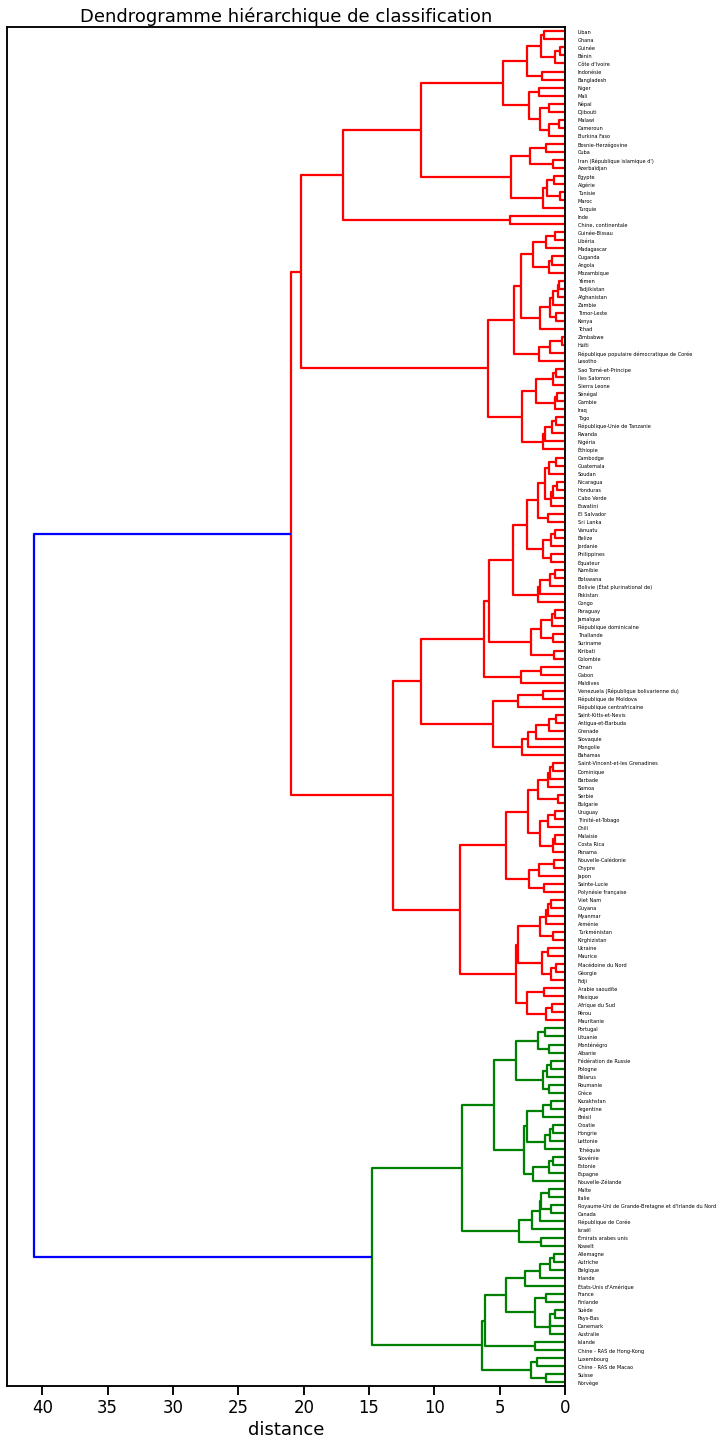

<Figure size 432x288 with 0 Axes>

In [24]:
# préparation des données pour le clustering
X = bilan_alim.values
names = bilan_alim.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')
dendrogram(Z,
        labels = names,
        orientation = "left")
plt.show()

plt.savefig(f'{dir}P5_01_dendrogramme.jpg')

In [25]:
cluster = fcluster(Z, t=5, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : bilan_alim.index.tolist(),
                             'ddg_cluster' : cluster})
data_cluster = data_cluster.sort_values(['ddg_cluster', 'pays'])
data_cluster.to_csv(f'{dir}P5_03_listepays.csv')

In [26]:
bilan_alim = pd.merge(bilan_alim, data_cluster, on = 'pays')
bilan_alim = bilan_alim.set_index('pays')
bilan_alim.head()

,dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,totale_prot,prop_prot_anim_veg,population,croissance_pop,dispo_prot_hab,totale_kcal,dispo_kcal_hab,pib_hab,rnb_hab,ddg_cluster
pays,,,,,,,,,,,,,,
Arménie,789.0,2283.0,44.56,52.77,97.33,0.457824,2944790.0,0.29,35525.45,3072.0,1121280.0,3933.682101,4091.789288,2
Afghanistan,190.0,1807.0,10.56,43.53,54.09,0.195230,36296110.0,2.58,19742.85,1997.0,728905.0,605.557362,608.535691,3
Albanie,1094.0,2306.0,66.32,53.18,119.50,0.554979,2884170.0,-0.08,43617.50,3400.0,1241000.0,4445.132198,4455.980443,1
Algérie,402.0,2943.0,25.70,67.15,92.85,0.276791,41389190.0,2.07,33890.25,3345.0,1220925.0,4051.244377,3999.792576,5
Angola,210.0,2056.0,16.47,37.62,54.09,0.304493,29816770.0,3.38,19742.85,2266.0,827090.0,4100.291004,3845.473230,3


### 6. Analyse en Composantes Principales

Pour réaliser notre analyse en composantes principales, on prépare les données. On va donc retrouver le nombre de composantes qui a été fixé à 2. En effet selon le critère de Kaiser, on ne retient que les composantes où le pourcentage d'inertie est supérieur à 20%. Ici, on a (100/p) = 20 avec p = 5. On ne devrait sélectionner qu'une seule composante mais il est nécessaire d'en avoir deux pour pouvoir établir le premier plan d'une analyse factorielle. 

In [27]:
n_comp = 4
data_pca = bilan_alim[['prop_prot_anim_veg', 'croissance_pop', 'dispo_prot_hab', 'dispo_kcal_hab', 'pib_hab', 'rnb_hab']]

X = data_pca.values
names = bilan_alim.index
features = data_pca.columns
illustrative_var = bilan_alim['ddg_cluster']

In [28]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [29]:
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

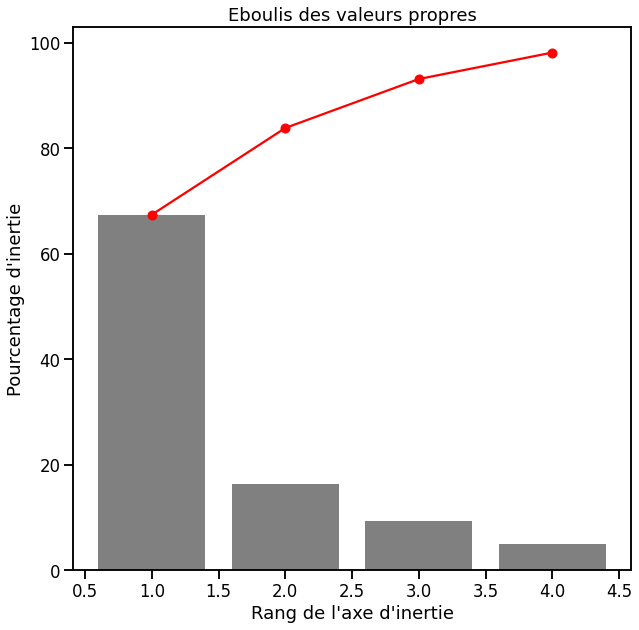

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_context('talk')

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

La représentation des éboulis des valeurs propres vient appuyer ce qui a été défini par le calcul du critère de Kaiser. La première composante F1 représente à elle seule 67% de l'inertie. 

Le traçage du cercle de corrélation va nous permettre de comprendre ce qui compose nos deux composantes F1 et F2.

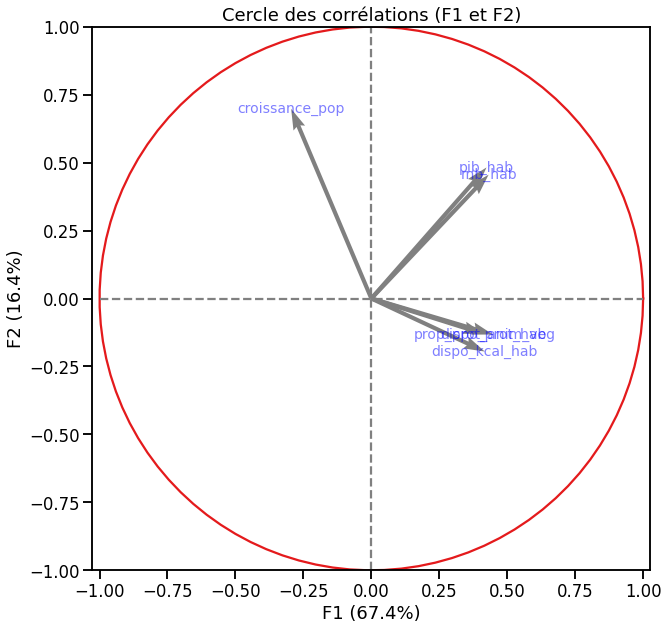

In [31]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

Les variables 'dispo_prot_hab', 'dispo_kcal_hab' et 'prop_prot_anim_veg' sont celles qui varient le plus sur l'axe F1. Ces trois variables sont en rapport avec la disponibilité alimentaire de ces pays. Ensuite, les variables 'croissance_pop', 'pib_hab' et 'rnb_hab' sont celles qui varient le plus sur l'axe F2. Ces trois indices sont en rapport avec l'économie du pays.

L'axe F1 explique 67% de l'inertie de notre échantillon et l'axe F2 va expliquer 16% de l'inertie. Les variations de notre échantillon peut donc s'expliquer par deux composantes :'disponibilité alimentaire' et 'santé économique'. 

Pour répondre à la deuxième partie de notre analyse exploratoire, on va projeter les individus sur le premier plan de notre analyse factorielle. Pour plus de simplicité, les labels n'ont pas été mis mais un code de couleur correspondant aux clusters définis plus tôt a été utilisé. 

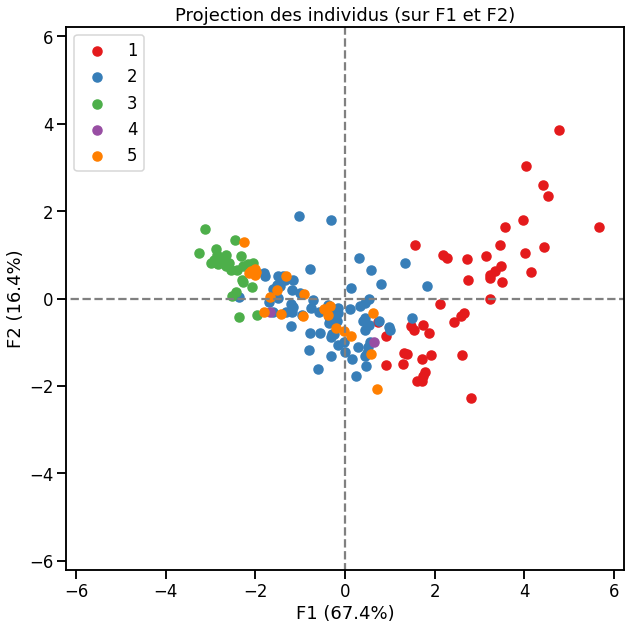

In [32]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

On retrouve nos 5 clusters définis par le dendrogramme. Le cluster 1 semble comprendre des pays où la disponibilité alimentaire est plutôt positive alors que le cluster 2 est composé de pays où la disponibilité alimentaire est négative. Concernant le cluster 3, il semble constituer de pays où la disponibilité alimentaire est négative et la croissance plutôt stable. Le cluster 4, quant à lui, est composé de deux pays uniquement. Enfin, le cluster 5 est un cluster composé de pays où la disponibilité alimentaire est mixte et la croissance économique est mixte aussi. 

Les pays composant les clusters 3 et 4 sont donc des pays où il semble intéressant de s'implanter.

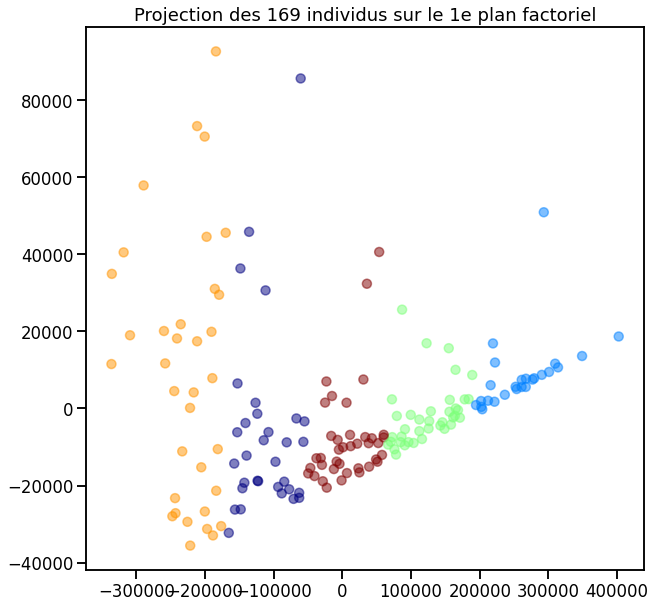

In [33]:
n_clust = 5

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=2).fit(X)
X_projected = pca.transform(X)
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.5)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show()

<Figure size 432x288 with 0 Axes>

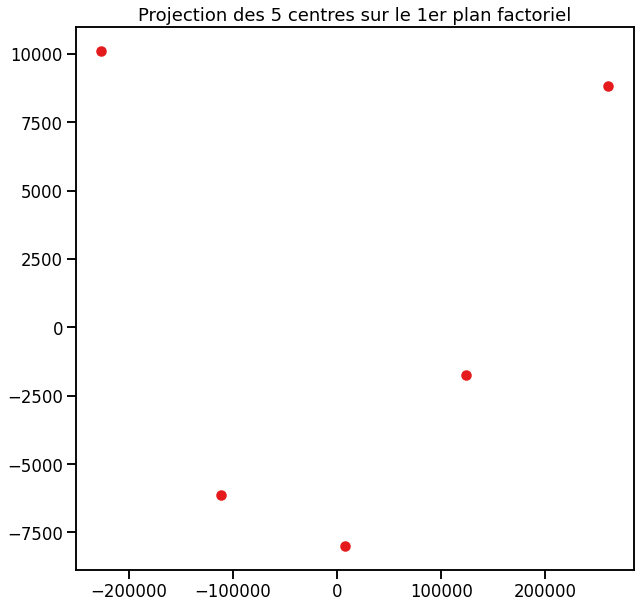

In [34]:
# Affichage des positions des centres de classes
plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1er plan factoriel".format(len(centroids)))
plt.show()

In [35]:
coord_centroids = pd.DataFrame(centroids)
coord_centroids = coord_centroids.rename(columns={0 : 'prop_prot_anim_veg',
                                                  1 : 'croissance_pop', 
                                                  2 : 'dispo_prot_hab',
                                                  3 : 'dispo_kcal_hab',
                                                  4 : 'pib_hab', 
                                                  5 : 'rnb_hab'})
coord_centroids['cluster'] = (1,2,3,4,5)
coord_centroids = coord_centroids.set_index('cluster')
coord_centroids = coord_centroids.reset_index()
coord_centroids.to_csv(f'{dir}P5_04_coordonneescentroides.csv')

### 7. Analyses statistiques

In [36]:
bilan_alim['ddg_cluster'].value_counts()

2    71
1    45
3    28
5    23
4     2
Name: ddg_cluster, dtype: int64

D'après notre découpage en 5 groupes, on remarque que le cluster 4 est composé de 2 pays (Chine continentale et Inde). On peut tenter de faire une partition en 4 groupes.

In [37]:
cluster = fcluster(Z, t=4, criterion='maxclust')
data_cluster = pd.DataFrame({'pays' : bilan_alim.index.tolist(),
                             'ddg_cluster4' : cluster})
data_cluster = data_cluster.sort_values(['ddg_cluster4', 'pays'])

In [38]:
data_cluster['ddg_cluster4'].value_counts()

2    71
1    45
3    28
4    25
Name: ddg_cluster4, dtype: int64

In [39]:
bilan_alim = pd.merge(bilan_alim, data_cluster, on='pays')
bilan_alim = bilan_alim.drop(columns='ddg_cluster')
bilan_alim = bilan_alim[['pays', 'population','prop_prot_anim_veg', 'croissance_pop', 'dispo_prot_hab', 'dispo_kcal_hab', 'pib_hab', 'rnb_hab', 'ddg_cluster4']]
bilan_alim = bilan_alim.set_index('pays')
bilan_alim = bilan_alim.sort_values('ddg_cluster4')
bilan_alim.head()

,population,prop_prot_anim_veg,croissance_pop,dispo_prot_hab,dispo_kcal_hab,pib_hab,rnb_hab,ddg_cluster4
pays,,,,,,,,
République de Corée,51096420.0,0.507064,0.22,35394.05,1230050.0,31852.314810,31982.151684,1
Slovénie,2076390.0,0.550310,0.11,35875.85,1168000.0,23347.227276,22924.824889,1
Islande,334390.0,0.713881,0.66,51589.10,1324585.0,73108.083207,73384.962299,1
Croatie,4182860.0,0.596363,-0.61,32915.70,1123835.0,13204.751536,12711.278905,1
Hongrie,9729820.0,0.567571,-0.24,32032.40,1200485.0,14556.367247,13972.224884,1


On recommence une partie de notre analyse en composante principale pour obtenir la nouvelle distribution de notre 4 clusters selon les composantes F1 et F2 définis plus tôt. 

In [40]:
n_comp = 4
data_pca = bilan_alim[['prop_prot_anim_veg', 'croissance_pop', 'dispo_prot_hab', 'dispo_kcal_hab', 'pib_hab', 'rnb_hab']]

X = data_pca.values
names = bilan_alim.index
features = data_pca.columns
illustrative_var = bilan_alim['ddg_cluster4']

std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

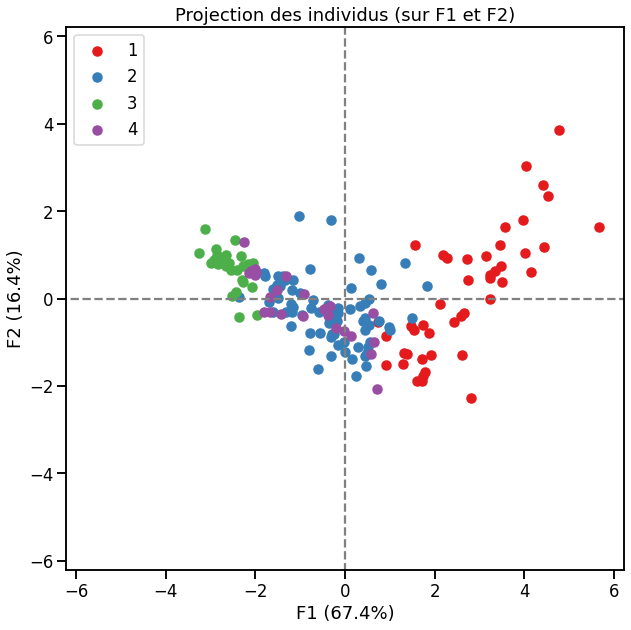

In [41]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)

### 7.1. Tests d'adéquation à une loi statistique

On effectue des tests d'adéquation à une loi statistique par l'intermédiaire du test de Kolmogorov-Smirnov.

Dans notre premier cas, l'hypothèse nulle (H0) est que la variable X (prop_prot_anim_veg) suit une loi normale. L'hypothèse alternative (H1) est que la variable prop_prot_anim_veg ne suit pas la loi normale. 

- H0 : prop_prot_anim_veg = loi normale
- H1 : prop_prot_anim_veg != loi normale

In [42]:
ks_2samp(bilan_alim["prop_prot_anim_veg"],list(np.random.normal(np.mean(bilan_alim["prop_prot_anim_veg"]), np.std(bilan_alim["prop_prot_anim_veg"]), 1000)))

Ks_2sampResult(statistic=0.07802958579881657, pvalue=0.3231918091176442)

On obtient une valeur D = 0.08. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution de la proportion de protéine animale par rapport à la proportion de protéine totale suit donc la loi normale. 

On s'intéresse ensuite à l'adéquation de la distribution de la croissance de population à la loi normale. On aura donc une hypothèse nulle (H0) où la croissance de population suit une loi normale. L'hypothèse alternative (H1) indique que notre variable d'intérêt ne suit pas la loi normale.

- H0 : croissance_pop = loi normale
- H1 : croissance_pop != loi normale

In [43]:
ks_2samp(bilan_alim["croissance_pop"],list(np.random.normal(np.mean(bilan_alim["croissance_pop"]), np.std(bilan_alim["croissance_pop"]), 1000)))

Ks_2sampResult(statistic=0.06893491124260355, pvalue=0.47441753857928715)

On obtient une valeur D = 0.06. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution de la croissance de la population suit donc la loi normale. 

Notre troisième test s'intéresse à la distribution de la disponibilité alimentaire en protéines par habitant. L'hypothèse nulle (H0) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H1) correspond à une non-adéquation à la loi normale. 

- H0 : dispo_prot_hab = loi normale
- H1 : dispo_prot_hab != loi normale

In [44]:
ks_2samp(bilan_alim["dispo_prot_hab"],list(np.random.normal(np.mean(bilan_alim["dispo_prot_hab"]), np.std(bilan_alim["dispo_prot_hab"]), 1000)))

Ks_2sampResult(statistic=0.0937810650887574, pvalue=0.14648099457591024)

On obtient une valeur D = 0.09. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution de la disponibilité alimentaire en protéines par habitant suit donc la loi normale. 

Notre quatrième test s'intéresse à la distribution de la disponibilité alimentaire en calories par habitant. L'hypothèse nulle (H0) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H1) correspond à une non-adéquation à la loi normale. 

- H0 : dispo_kcal_hab = loi normale
- H1 : dispo_kcal_hab != loi normale

In [45]:
ks_2samp(bilan_alim["dispo_kcal_hab"],list(np.random.normal(np.mean(bilan_alim["dispo_kcal_hab"]), np.std(bilan_alim["dispo_kcal_hab"]), 1000)))

Ks_2sampResult(statistic=0.08677514792899409, pvalue=0.21222996622811663)

On obtient une valeur D = 0.06. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On ne peut donc pas rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution de la disponibilité alimentaire en calories par habitant suit donc la loi normale. 

Notre cinquième test s'intéresse à la distribution du Produit Intérieur Brut (PIB) par habitant. L'hypothèse nulle (H0) correspond à une adéquation de la distribution à une loi normale alors que l'hypothèse alternative (H1) correspond à une non-adéquation à la loi normale. 

- H0 : pib_hab = loi normale
- H1 : pib_hab != loi normale

In [46]:
ks_2samp(bilan_alim["pib_hab"],list(np.random.normal(np.mean(bilan_alim["pib_hab"]), np.std(bilan_alim["pib_hab"]), 1000)))

Ks_2sampResult(statistic=0.249, pvalue=2.2265823629297188e-08)

On obtient une valeur D = 0.25. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On peut donc rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution du produit intérieur brut ne suit donc pas une loi normale (ou gaussienne).

Enfin, notre dernier test s'intéresse à la distribution du Revenu National Brut (RNB) par habitant. L'hypothèse nulle (H0) correspond à l'adéquation de la distributio à une loi normale alors que l'hypothèse alternative (H1) correspond à la non-adéquation à la loi normale.

- H0 : rnb_hab = loi normale
- H1 : rnb_hab != loi normale

In [47]:
ks_2samp(bilan_alim["rnb_hab"],list(np.random.normal(np.mean(bilan_alim["rnb_hab"]), np.std(bilan_alim["rnb_hab"]), 1000)))

Ks_2sampResult(statistic=0.2634733727810651, pvalue=2.451082559140616e-09)

On obtient une valeur D = 0.24. Selon la table de Kolmogorov-Smirnov pour un échantillon N = 169 et un coefficient alpha = 0.05, on obtient 1.358/sqrt(169) = 0.10. On peut donc rejeter l'hypothèse nulle (H0) à un coefficient alpha 5%. La distribution du revenu national brut (RNB) ne suit donc pas une loi normale (ou gaussienne).

### 7.2. Tests de comparaison entre deux populations

Une fois que l'on a déterminé les variables qui suivent une loi normale et celles qui ne la suivent pas. On peut s'intéresser à la réalisation de statistiques inférentielles pour comparer les moyennes dans deux de nos clusters. On va s'intéresser aux clusters 1 et 2.
En effet, ces deux clusters ont l'avantage d'avoir des proportions de protéine animale représentant environ 50% indiquant qu'ils consomment autant de protéines animale que végétale.

In [48]:
clust1 = bilan_alim[bilan_alim["ddg_cluster4"]==1]["prop_prot_anim_veg"]
clust2 = bilan_alim[bilan_alim["ddg_cluster4"]==2]["prop_prot_anim_veg"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=11.536211325108667, pvalue=0.0006825359134340864)

In [49]:
st.stats.ttest_ind(clust1,clust2, equal_var=True)

Ttest_indResult(statistic=7.25190862999725, pvalue=5.3051177958589667e-11)

In [50]:
clust1 = bilan_alim[bilan_alim["ddg_cluster4"]==1]["croissance_pop"]
clust2 = bilan_alim[bilan_alim["ddg_cluster4"]==2]["croissance_pop"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=3.463322185451638, pvalue=0.06274413171607972)

In [51]:
st.stats.ttest_ind(clust1,clust2, equal_var=True)

Ttest_indResult(statistic=-3.6658488655479666, pvalue=0.0003758637421135388)

In [52]:
bilan_alim_2 = pd.pivot_table(bilan_alim, columns='ddg_cluster4', aggfunc=np.mean)
bilan_alim_2 = bilan_alim_2.transpose()
bilan_alim_2 = bilan_alim_2[['croissance_pop', 'pib_hab', 'rnb_hab', 'dispo_kcal_hab', 'dispo_prot_hab', 'prop_prot_anim_veg']]
bilan_alim_2

,croissance_pop,pib_hab,rnb_hab,dispo_kcal_hab,dispo_prot_hab,prop_prot_anim_veg
ddg_cluster4,,,,,,
1,0.480000,36688.563555,35354.033453,1.236628e+06,38747.832222,0.588681
2,1.138451,8548.844381,8351.506443,9.915662e+05,27694.349296,0.469795
3,2.455714,1252.173853,1220.975130,8.197118e+05,20287.873214,0.216697
4,1.751200,3365.049453,3333.165100,1.085963e+06,28939.828000,0.255416


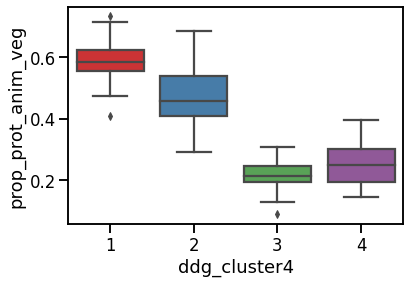

In [53]:
_ = sns.boxplot(x='ddg_cluster4', y='prop_prot_anim_veg', data=bilan_alim)
_ = plt.show()

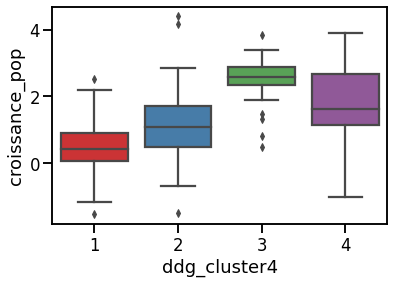

In [54]:
_ = sns.boxplot(x='ddg_cluster4', y='croissance_pop', data=bilan_alim)
_ = plt.show()

In [55]:
x = bilan_alim['dispo_prot_hab']
y = bilan_alim['dispo_kcal_hab']

print('rho de pearson :', st.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = bilan_alim['dispo_kcal_hab']
X = bilan_alim[['dispo_prot_hab']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['dispo_prot_hab'],result.params['intercept']
print('r-squared : ', (st.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.8787998328773228
indice de covariation : 1085102627.4968407
r-squared :  0.7722891462652104


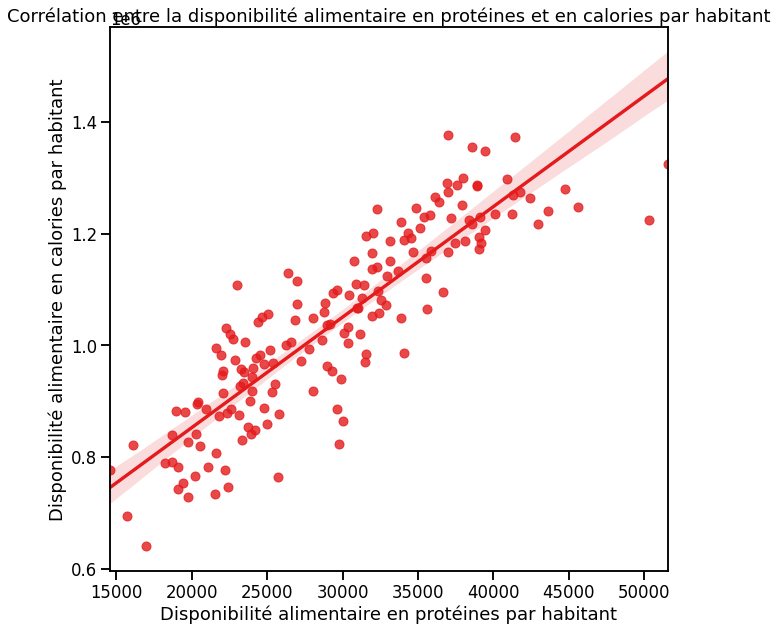

In [56]:
sns.set_context('talk')
sns.set_palette('Set1')

_ = plt.figure(figsize = (10,10))
_ = sns.regplot('dispo_prot_hab', 'dispo_kcal_hab', data=bilan_alim)
_ = plt.xlabel("Disponibilité alimentaire en protéines par habitant")
_ = plt.ylabel("Disponibilité alimentaire en calories par habitant")
_ = plt.title("Corrélation entre la disponibilité alimentaire en protéines et en calories par habitant")

_ = plt.show()

In [57]:
clust1 = bilan_alim[bilan_alim["ddg_cluster4"]==1]["dispo_prot_hab"]
clust2 = bilan_alim[bilan_alim["ddg_cluster4"]==2]["dispo_prot_hab"]
st.stats.bartlett(clust1,clust2)

BartlettResult(statistic=0.02673872749187956, pvalue=0.8701091787983861)

In [58]:
st.stats.ttest_ind(clust1,clust2, equal_var=True)

Ttest_indResult(statistic=14.02587053336525, pvalue=1.405334535172556e-26)

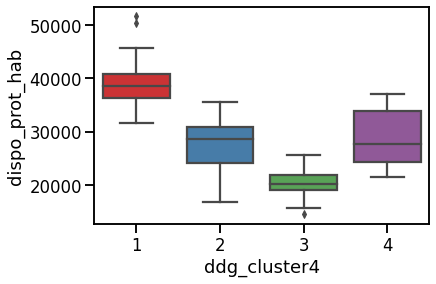

In [59]:
_ = sns.boxplot(x='ddg_cluster4', y='dispo_prot_hab', data=bilan_alim)
_ = plt.show()